In [4]:
import numpy as np #for numerical array data
import pandas as pd #for tabular data
import matplotlib.pyplot as plt #for plotting purposes
import matplotlib.pylab as pl #for plotting purposes

import csv
from datetime import datetime, timedelta

from matplotlib.collections import LineCollection #for plotting purposes
from sklearn import cluster, covariance, manifold #for graphical analysis

In [5]:
file_name = 'https://github.com/nick-dahl/AI_Finance/blob/main/firms_info.csv?raw=true'
firms_info = pd.read_csv(file_name, index_col=0)

# Load dataset for T-Bill
df_rf = pd.read_csv('https://github.com/nick-dahl/AI_Finance/blob/main/tbill.csv?raw=true', index_col=0)
df_rf.index=pd.to_datetime(df_rf.index)

# Load Stock Return dataset
df = pd.read_csv('https://github.com/nick-dahl/AI_Finance/blob/main/CleanedData_Weekly.csv?raw=true', index_col=0)
df.index=pd.to_datetime(df.index)
data = df.copy()

Explore these functions

In [6]:
# Function used to find the Annualized Sharpe Ratio of x
def sr_annu(x_old,rf_old):
    index = x_old.index[x_old.apply(np.isnan)]
    x = x_old.drop(index).values
    rf = rf_old.drop(index).values

    n = len(x)
    ret_expected = np.sum(x-rf)/n
    std_dev = np.sqrt( np.sum( (x-rf - ret_expected)**2 ) / n )
    annu_ret_expected = (ret_expected+1)**52-1
    annu_std_dev = std_dev * np.sqrt(52)
    return annu_ret_expected/annu_std_dev

# Function used to find the Maximum drawdown
def mdd(x):
    #x is a return vector
    wealth = (x+1).cumprod()
    #determine cumulative maximum value
    cummax = wealth.cummax()
    #calculate drawdown vector
    drawdown = wealth/cummax - 1
    return drawdown.min()

# Function for getting Summary Statistic information, including:
# total returns, average returns, annualized average return, annualized standard deviation,
# annualized sharpe ratio, and maximum drawdown
# NOTE: it will drop the firms that have missing data during the specified time period
def getSumStat(data, rf = df_rf['T-Bill'], rounding = 2):

    # Get the Start and End date of the dataset
    date_obj = data.index[0]
    start_of_week = date_obj - timedelta(days=date_obj.weekday())
    start = start_of_week.strftime("%m/%d/%Y")
    end =  data.index[-1].strftime("%m/%d/%Y")

    print('Summary Statistic Information from ' + start + ' to ' + end + ':')
    # Check if there is NA in the dataset within the given time period
    # If yes, then drop those firms before calculating its summary statistics
    if(data.isnull().values.any()):
        print('WARNING: Some firms have missing data during this time period!')
        print('Dropping firms: ')
        for Xcol_dropped in list(data.columns[data.isna().any()]): print(Xcol_dropped)
        data = data.dropna(axis='columns')

    sectors = firms_info.Sector
    ss_temp = pd.DataFrame(sectors, index = data.columns, columns=['Sector'])
    ss_temp['Total Return(%)'] = np.round((((data+1).cumprod()-1)*100).iloc[-1] , rounding)
    ss_temp['Ave Return(%)'] = np.round(data.mean()*100, rounding)
    ss_temp['Annu. Ave Return(%)'] = np.round(((data.mean()+1)**52-1)*100, rounding)
    ss_temp['Annu. Std(%)'] = np.round(data.std()*np.sqrt(52)*100, rounding)
    ss_temp['Annu. Sharpe Ratio'] = np.round(data.apply(sr_annu, rf_old=rf), rounding)
    ss_temp['Max Drawdown(%)'] = np.round(data.apply(mdd)*100, rounding)
    return(ss_temp)

In [7]:
# Function for performing graphical network analysis
# Print clusters information, graphical network information, summary statistics, and plot of individual firm performance
# Return correlation and precision matrix, as well as plotting configuration information
# NOTE: it will drop the firms that have missing data during the specified time period

def graphicalAnalysis(dataset, start_date = '2000-01-01', end_date = '2020-05-31',
                      Sectors_chosen = [],
                      drop_firm = [],
                      display_SumStat = True, display_IndRet = True,
                      data_rf = df_rf):

    # Check if the inputed date are legit
    if(datetime.strptime(start_date, "%Y-%m-%d") > datetime.strptime(end_date, "%Y-%m-%d")):
        print('ERROR: Revision needed! The entered \"start_date\" should be before \"end_date\".')
        return 0,0
    if (dataset.index[0]- timedelta(days=dataset.index[0].weekday()) > datetime.strptime(start_date, "%Y-%m-%d")):
        print('WARNING: the entered \"start_date\" is outside of the range for the given dataset.')
        print('The \"start_date\" is adjusted to the earliest start_date, i.e. ',
              (dataset.index[0]-timedelta(days=dataset.index[0].weekday())).strftime("%Y-%m-%d"))
        print()
    if (dataset.index[-1] < datetime.strptime(end_date, "%Y-%m-%d")):
        print('WARNING: the entered \"end_date\" is outside of the range for the given dataset.')
        print('The \"end_date\" is adjusted to the lastest end_date, i.e. ',
              dataset.index[-1].strftime("%Y-%m-%d"))
        print()

    # Extract the data for the given time period
    temp = dataset[dataset.index >= start_date].copy()
    X = temp[temp.index <= end_date].copy()
    temp = data_rf[data_rf.index >= start_date].copy()
    data_rf2 = temp[temp.index <= end_date].copy()

    # Check if we are using all sectors or dropping some sector
    if ((not Sectors_chosen) == False):
        if(all([(s in firms_info.Sector.unique()) for s in Sectors_chosen])):
            f_in_sector_chosen = []
            for s in Sectors_chosen:
                f_in_sector_chosen += list(firms_info[firms_info.Sector == s].index)
            X = X[f_in_sector_chosen]
            print('Sectors choosen in the Graphical Analysis are:')
            print(Sectors_chosen)
            print()
        else:
            print('ERROR: Revision needed! At Least 1 Sector entered in the \"Sectors_choosen\" option is NOT in the dataset!')
            print('Check your format!')
            return 0,0

    # Check if we are using all firm or dropping some firms
    if((not drop_firm) == False):
        if(all([(f in X.columns) for f in drop_firm])):
            print('The following Firms are dropped:')
            print(drop_firm)
            print()
            X.drop(columns = drop_firm, inplace = True)
        else:
            print('ERROR: Revision needed! At Least 1 firm entered in the \"drop_firm\" option is NOT in the dataset!')
            print('Check your format!')
            return 0,0

    # Check if there is NA in the dataset within the given time period
    # If yes, then drop those firms before doing graphical analysis
    if(X.isnull().values.any()):
        print('WARNING: Some firms have missing data during this time period!')
        print('Dropping firms: ')
        for Xcol_dropped in list(X.columns[X.isna().any()]): print(Xcol_dropped)
        X = X.dropna(axis='columns')
        print()

    # Get the Start and End date of the dataset
    date_obj = X.index[0]
    start_of_week = date_obj - timedelta(days=date_obj.weekday())
    start = start_of_week.strftime("%m/%d/%Y")
    end =  X.index[-1].strftime("%m/%d/%Y")

    # Get the firm names of the dataset
    names = np.array(list(X.columns))

    # Show the number of firms examined
    print('Number of firms examined:', X.shape[1])


    # #############################################################################
    # Learn a graphical structure from the correlations

    # Graphical Lasso is used here to estimate the precision matrix
    edge_model = covariance.GraphicalLassoCV(max_iter=1000)

    # standardize the time series:
    # using correlations rather than covariance is more efficient for structure recovery
    X_std = X / X.std(axis=0)
    edge_model.fit(X_std)

    # #############################################################################
    # Cluster using affinity propagation

    _, labels = cluster.affinity_propagation(edge_model.covariance_)
    n_labels = labels.max()

    for i in range(n_labels + 1):
        print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

    # #############################################################################
    # Find a low-dimension embedding for visualization: find the best position of
    # the nodes (the stocks) on a 2D plane

    node_position_model = manifold.MDS(n_components=2, random_state=0)
    embedding = node_position_model.fit_transform(X_std.T).T

    # #############################################################################
    # Visualization I

    # Specify node colors by cluster labels
    color_list = pl.cm.jet(np.linspace(0,1,n_labels+1))
    my_colors = [color_list[i] for i in labels]

    # Compute the partial correlations
    partial_correlations = edge_model.precision_.copy()
    d = 1 / np.sqrt(np.diag(partial_correlations))
    partial_correlations *= d
    partial_correlations *= d[:, np.newaxis]
    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

    # Compute the edge values based on the partial correlations
    values = np.abs(partial_correlations[non_zero])
    val_max = values.max()

    # Title of the plot
    title = 'Graphical Network Analysis of Selected Firms over the Period '+start+' to '+end+' (Weekly)'

    # Display the partial correlation graph
    graphicalAnalysis_plot(d, partial_correlations, my_colors,
                           names, labels, embedding, val_max, title)

    # The configuration of the plot
    plot_config = [d, partial_correlations, my_colors, names, labels, embedding, val_max, title]

    # #############################################################################
    # Visualization II

    # For individual firm performance over the given period
    if (display_IndRet):
        print('Individual Stock Performance over the Period '+ start+' to '+end+' (Weekly):')
        l_r = int(np.ceil(len(names)/4))
        l_c = 4
        f_hei = l_r * 2.5
        f_wid = l_c * 4
        ax = (X+1).cumprod().plot(subplots=True, layout=(l_r, l_c), figsize=(f_wid, f_hei),
                                  logy=True, sharex=True, sharey=True, x_compat=True,
                                  color = my_colors);
        for i in range(l_c):
            ax[0,i].xaxis.set_tick_params(which='both', top = True, labeltop=True, labelrotation=40)
        plt.show()

    # #############################################################################
    # Show summary statistics for each firm over the given period
    if (display_SumStat):
        display(getSumStat(X, rf = data_rf2['T-Bill']))

    return [edge_model.covariance_, edge_model.precision_], plot_config

# Function Used for plotting the graphical network graph
def graphicalAnalysis_plot(d, partial_correlations, my_colors,
                           names, labels, embedding, val_max, title):

    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)
    n_labels = labels.max()

    #For correlation network graph
    fig = plt.figure(1, facecolor='w', figsize=(12, 5))
    plt.clf()
    ax = plt.axes([0., 0., 1., 1.])
    plt.axis('off')

    # Plot the nodes using the coordinates of our embedding
    plt.scatter(embedding[0], embedding[1], s=500 * d ** 2, c= my_colors)

    # Plot the edges
    start_idx, end_idx = np.where(non_zero)
    # a sequence of (*line0*, *line1*, *line2*), where::
    #            linen = (x0, y0), (x1, y1), ... (xm, ym)
    segments = [[embedding[:, start], embedding[:, stop]]
                for start, stop in zip(start_idx, end_idx)]
    values = np.abs(partial_correlations[non_zero])
    lc = LineCollection(segments,
                        zorder=0, cmap=plt.cm.hot_r,
                        norm=plt.Normalize(0, .7 * val_max))
    lc.set_array(values)
    temp = (15 * values)
    temp2 = np.repeat(5, len(temp))
    w = np.minimum(temp, temp2)
    lc.set_linewidths(w)
    ax.add_collection(lc)
    axcb = fig.colorbar(lc)
    axcb.set_label('Strength')

    # Add a label to each node. The challenge here is that we want to
    # position the labels to avoid overlap with other labels
    for index, (name, label, (x, y)) in enumerate(
            zip(names, labels, embedding.T)):

        dx = x - embedding[0]
        dx[index] = 1
        dy = y - embedding[1]
        dy[index] = 1
        this_dx = dx[np.argmin(np.abs(dy))]
        this_dy = dy[np.argmin(np.abs(dx))]
        if this_dx > 0:
            horizontalalignment = 'left'
            x = x + .002
        else:
            horizontalalignment = 'right'
            x = x - .002
        if this_dy > 0:
            verticalalignment = 'bottom'
            y = y + .002
        else:
            verticalalignment = 'top'
            y = y - .002
        plt.text(x, y, name, size=10,
                 horizontalalignment=horizontalalignment,
                 verticalalignment=verticalalignment,
                 bbox=dict(facecolor='w',
                           edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                           alpha=.6))

    x = embedding[0]
    y = embedding[1]

    dx = np.ptp(x)
    dy = np.ptp(y)

    plt.xlim(x.min() - .15 * dx,
         x.max() + .10 * dx)
    plt.ylim(y.min() - .03 * dy,
         y.max() + .03 * dy)

    plt.title(title)
    plt.show()

# Function Used for plotting the graphical network graph for the specified sectors
# Can be used to see more details of the network graph
def graphicalAnalysis_plot_ZOOM_bySector(Sectors_list, plot_config):

    d = plot_config[0]
    pc = plot_config[1]
    my_colors = np.array(plot_config[2])
    names = plot_config[3]
    labels = plot_config[4]
    embedding = plot_config[5]
    val_max = plot_config[6]
    title = 'ZOOM IN VIEW: ' + plot_config[7]

    if ((not Sectors_list) == False):
        if(all([(s in firms_info.Sector.unique()) for s in Sectors_list])):
            f_in_sector_chosen = []
            for s in Sectors_list:
                f_in_sector_chosen += list(firms_info[firms_info.Sector == s].index)
        else:
            print('ERROR: Revision needed! At Least 1 Sector entered in the \"Sectors_choosen\" option is NOT in the dataset!')
            print('Check your format!')
    else:
        print('Error: Need to enter the sectors you wanted to examine in the \"Sectors_list\" option!')
        return

    f_selected = list(set(f_in_sector_chosen).intersection(set(names)))

    if(not f_selected):
        print('ERROR: Revision needed! No firms in the selected sectors!')
        print('Check your format!')
        print('Note that the sectors entered in the \"Sectors_list\" option should also be in the \"Sectors_choosen\" option!')
        return
    else:
        ind = np.array([np.where(names == i)[0][0] for i in f_selected])

    graphicalAnalysis_plot(d[ind], pc[ind[:, None], ind], my_colors[ind],
                           names[ind], labels[ind], embedding[:,ind], val_max, title)
    
# Function Used for plotting the graphical network graph for the specified firms
# Can be used to see more details of the network graph
def graphicalAnalysis_plot_ZOOM_byFirm(firms_list, plot_config):

    d = plot_config[0]
    pc = plot_config[1]
    my_colors = np.array(plot_config[2])
    names = plot_config[3]
    labels = plot_config[4]
    embedding = plot_config[5]
    val_max = plot_config[6]
    title = 'ZOOM IN VIEW: ' + plot_config[7]

    if( all([(f in names) for f in firms_list]) ):
        if (not firms_list):
            print('Error: Need to enter the firms you wanted to examine in the \"firms_list\" option!')
            return
        else:
            ind = np.array([np.where(names == i)[0][0] for i in firms_list])
    else:
        print('Error: Revision needed! At Least 1 firm entered in the \"firms_list\" are NOT in the dataset!')
        print('Check your format and also whether the firms are dropped due to missing data!')
        return

    graphicalAnalysis_plot(d[ind], pc[ind[:, None], ind], my_colors[ind],
                           names[ind], labels[ind], embedding[:,ind], val_max, title)

In [8]:
firms_info

,Name,Sector
Ticker,,
FRC,First Republic,Bank
PNC,PNC Financial,Bank
USB,US Bancorp,Bank
JPM,JPMorgan Chase,Bank
BAC,Bank of America,Bank
C,Citigroup,Bank
RY,Royal Bank of Canada,Bank
WFC,Wells Fargo,Bank
GS,Goldman Sachs,Bank


Unique industries we will be considering:

In [9]:
Sectors = firms_info.Sector.unique()
print(Sectors)

['Bank' 'Health' 'Energy' 'Tech' 'Market Index']


In [10]:
data

,FRC,PNC,USB,JPM,BAC,C,RY,WFC,GS,MS,...,MRK,XOM,RDS,CVS,BP,AAPL,GOOG,MSFT,BABA,SP500
date,,,,,,,,,,,,,,,,,,,,,
2000-01-09,NaN,-0.032304,-0.049869,-0.058139,-0.029888,-0.030302,-0.042493,-0.032457,-0.123426,-0.113398,...,0.115349,0.054307,NaN,0.042568,0.003161,-0.032218,NaN,-0.045503,NaN,-0.018908
2000-01-16,NaN,0.097264,0.019338,0.015465,0.034659,0.074074,-0.017752,0.065494,0.037093,0.088261,...,-0.010843,-0.013980,NaN,-0.036678,-0.070379,0.009422,NaN,0.007291,NaN,0.016428
2000-01-23,NaN,-0.061498,-0.094850,-0.012690,-0.093051,-0.026939,-0.035181,-0.121438,0.002128,-0.035047,...,-0.022765,0.014925,NaN,0.017960,0.016948,0.108278,NaN,-0.075724,NaN,-0.016237
2000-01-30,NaN,0.045583,0.005989,0.051414,0.001367,-0.005537,0.068037,0.058020,0.015318,-0.044340,...,0.054358,-0.072060,NaN,-0.067749,-0.041110,-0.087029,NaN,-0.053012,NaN,-0.056336
2000-02-06,NaN,-0.028609,0.014881,0.066015,-0.008197,-0.021727,-0.054815,0.000774,-0.026581,0.037512,...,-0.017185,0.025358,NaN,-0.048448,-0.086906,0.062731,NaN,0.084604,NaN,0.047208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31,0.111717,0.090144,0.079866,0.087626,0.064430,0.086395,0.101580,0.095159,0.098984,0.101420,...,0.056960,0.019506,-0.008995,0.015730,0.006964,-0.002980,0.014351,-0.001417,0.038508,0.030066
2020-06-07,0.110382,0.122675,0.191507,0.143049,0.173256,0.228554,0.109022,0.196449,0.109063,0.120588,...,0.019078,0.167364,0.182160,0.099345,0.197494,0.042649,0.004535,0.021555,0.058633,0.049147
2020-06-14,-0.111648,-0.134890,-0.114703,-0.102130,-0.118463,-0.112299,-0.064237,-0.116829,-0.074064,-0.065617,...,-0.065038,-0.111341,-0.087901,-0.083523,-0.106819,0.022022,-0.018820,0.002886,-0.008699,-0.047783


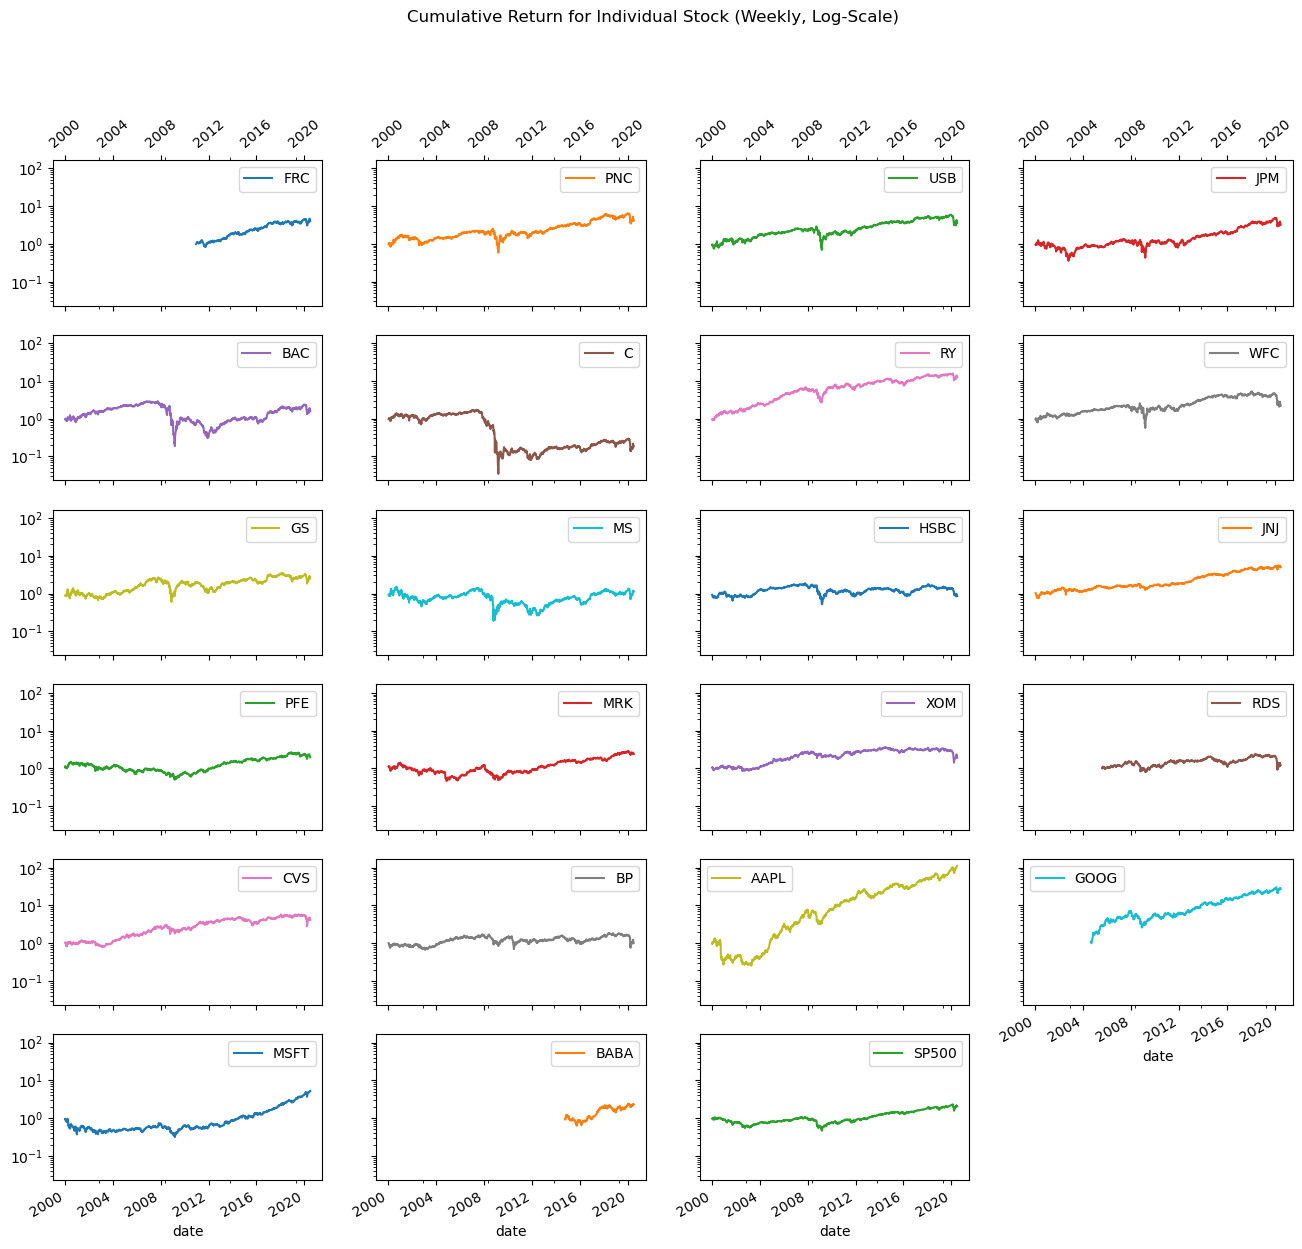

In [11]:
#plot cumulative return for each firm
lo_col = 4
lo_row = int(np.ceil(len(df.columns)/4))

f_hei = lo_row * 2.5
f_wid = lo_col * 4

ax = (data + 1).cumprod().plot(subplots=True, layout=(lo_row, lo_col), figsize=(f_wid, f_hei),
                               logy=True, sharex=True, sharey=True, x_compat=True, 
                               title = "Cumulative Return for Individual Stock (Weekly, Log-Scale)");

for i in range(lo_col):
    ax[0,i].xaxis.set_tick_params(which='both', top = True, labeltop=True, labelrotation=40)
plt.show()

For each firm, we will return the following values:

- Total Return
- Average return,
- Annualized Average return,
- Annualized standard deviation,
- Annualized Sharpe Ratio,
- Maximum drawdown.

In [12]:
getSumStat(data) #call this function that was created, research what it does

Summary Statistic Information from 01/03/2000 to 06/28/2020:
Dropping firms: 
FRC
RDS
GOOG
BABA


,Sector,Total Return(%),Ave Return(%),Annu. Ave Return(%),Annu. Std(%),Annu. Sharpe Ratio,Max Drawdown(%)
PNC,Bank,311.54,0.25,14.05,35.74,0.34,-76.64
USB,Bank,260.58,0.23,12.75,34.18,0.32,-76.09
JPM,Bank,224.48,0.24,13.45,37.46,0.31,-71.51
BAC,Bank,56.75,0.24,13.07,46.04,0.25,-93.46
C,Bank,-81.53,0.10,5.61,53.84,0.07,-97.97
RY,Bank,1182.27,0.30,16.61,24.27,0.61,-60.28
WFC,Bank,125.06,0.21,11.28,37.52,0.25,-77.71
GS,Bank,153.40,0.22,11.88,37.01,0.27,-77.20
MS,Bank,12.70,0.24,13.19,49.77,0.23,-87.57
HSBC,Bank,-14.04,0.05,2.78,26.18,0.04,-72.16


Since some firms have missing data for the whole time period given in the dataset...

In [13]:
firm_name = 'FRC'
start_date = '2010-12-12'
end_date   = '2020-06-28'

data[firm_name].first_valid_index()

Timestamp('2010-12-12 00:00:00')

In [14]:
# Output the summary statistics of the data for the given time period
ind = (data.index >= start_date)*(data.index <= end_date)
#get all indexes after the start date and before the end date
#pass that in our getSumStat function
display(getSumStat(data[ind], rf = df_rf['T-Bill'][ind]))

Summary Statistic Information from 12/06/2010 to 06/28/2020:
Dropping firms: 
BABA


,Sector,Total Return(%),Ave Return(%),Annu. Ave Return(%),Annu. Std(%),Annu. Sharpe Ratio,Max Drawdown(%)
FRC,Bank,299.96,0.34,19.47,25.94,0.72,-33.06
PNC,Bank,123.35,0.23,12.51,26.13,0.45,-46.63
USB,Bank,83.36,0.18,9.65,24.16,0.37,-48.13
JPM,Bank,200.97,0.29,16.23,26.72,0.58,-39.64
BAC,Bank,119.38,0.27,14.75,33.53,0.42,-66.00
C,Bank,22.89,0.16,8.42,34.47,0.23,-53.90
RY,Bank,82.56,0.16,8.62,19.95,0.40,-35.26
WFC,Bank,15.97,0.10,5.29,26.96,0.17,-60.90
GS,Bank,34.27,0.14,7.52,29.02,0.24,-48.89
MS,Bank,116.13,0.26,14.68,33.70,0.42,-58.41


Algorithm takes weekly returns of stocks as input, and feeds it into three unsupervised learning techniques in this order:

- *Sparse Inverse Covariance Estimation*, outputs a sparse matrix whose elements represent the conditional correlation between any two stock returns (estimator we use is Graphical Lasso). Gives information about which stocks are correlated conditionally on the others.
- *Affinity Propgation*, like K-Means, is a clustering method that organizes the returns into clusters. 
- *Manifold Learning*, projects a high-dimensional graph on a 2D plane. Each node corresponds to a stock, with color being defined by the cluster label from Affinity Propogation. Each edge links two stocks (the strength of the edge is defined by teh sparse inverse covariance matrix.)
    - Manifold 2d learning method is called **Multidimensional Scaling (MDS)**.
    - Think of it as like a 3d chemistry molecule structure but in higher dimensions.

References:
- https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html
- https://scikit-learn.org/stable/modules/covariance.html#sparse-inverse-covariance
- https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation
- https://scikit-learn.org/stable/modules/manifold.html#multi-dimensional-scaling-mds

In [15]:
#CAN BE CHANGED
## Start and End date we are considering:
start_date = '2020-01-01'
end_date   = '2020-06-28'

## Sectors which we will be testing:
Sectors_chosen = ['Bank','Health','Energy','Tech']

## The list of firms we want to drop:
drop_firm = []

## Whether we want to display the summary statisitcs and/or individual firm performance:
display_SumStat = True
display_IndRet = True

Results over the time period  2020-01-01  to  2020-06-28 :

Sectors choosen in the Graphical Analysis are:
['Bank', 'Health', 'Energy', 'Tech']

Number of firms examined: 22


c:\Users\kevin\anaconda3\envs\myenv\Lib\site-packages\numpy\_core\_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\kevin\anaconda3\envs\myenv\Lib\site-packages\sklearn\covariance\_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -6.509e-04
  warnings.warn(
c:\Users\kevin\anaconda3\envs\myenv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Cluster 1: FRC, PNC, USB, JPM, BAC, C, RY, WFC, GS, MS, HSBC
Cluster 2: JNJ, PFE, MRK
Cluster 3: XOM, RDS, CVS, BP
Cluster 4: AAPL, GOOG, MSFT
Cluster 5: BABA


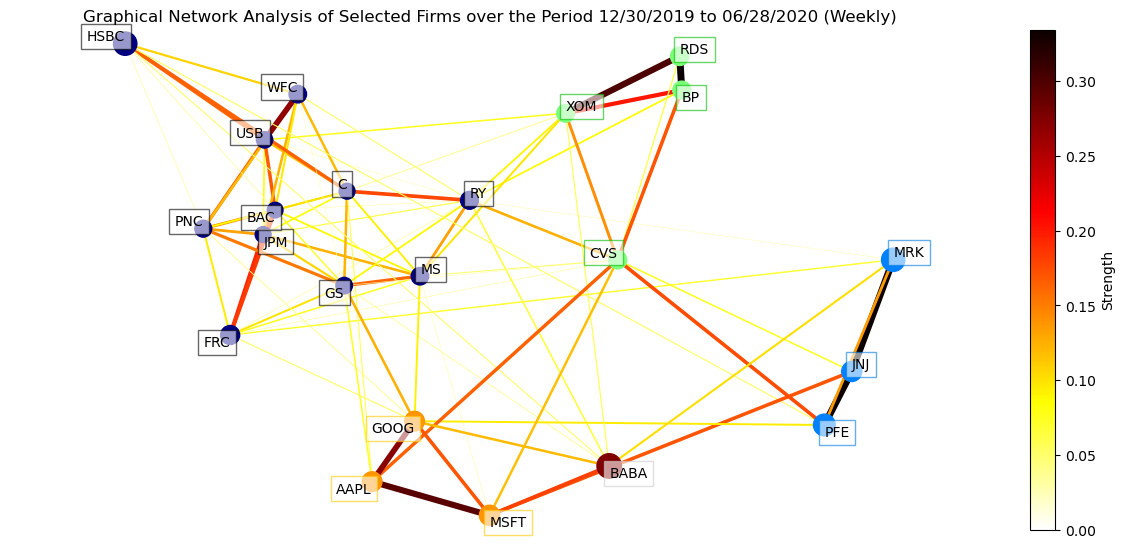

Individual Stock Performance over the Period 12/30/2019 to 06/28/2020 (Weekly):


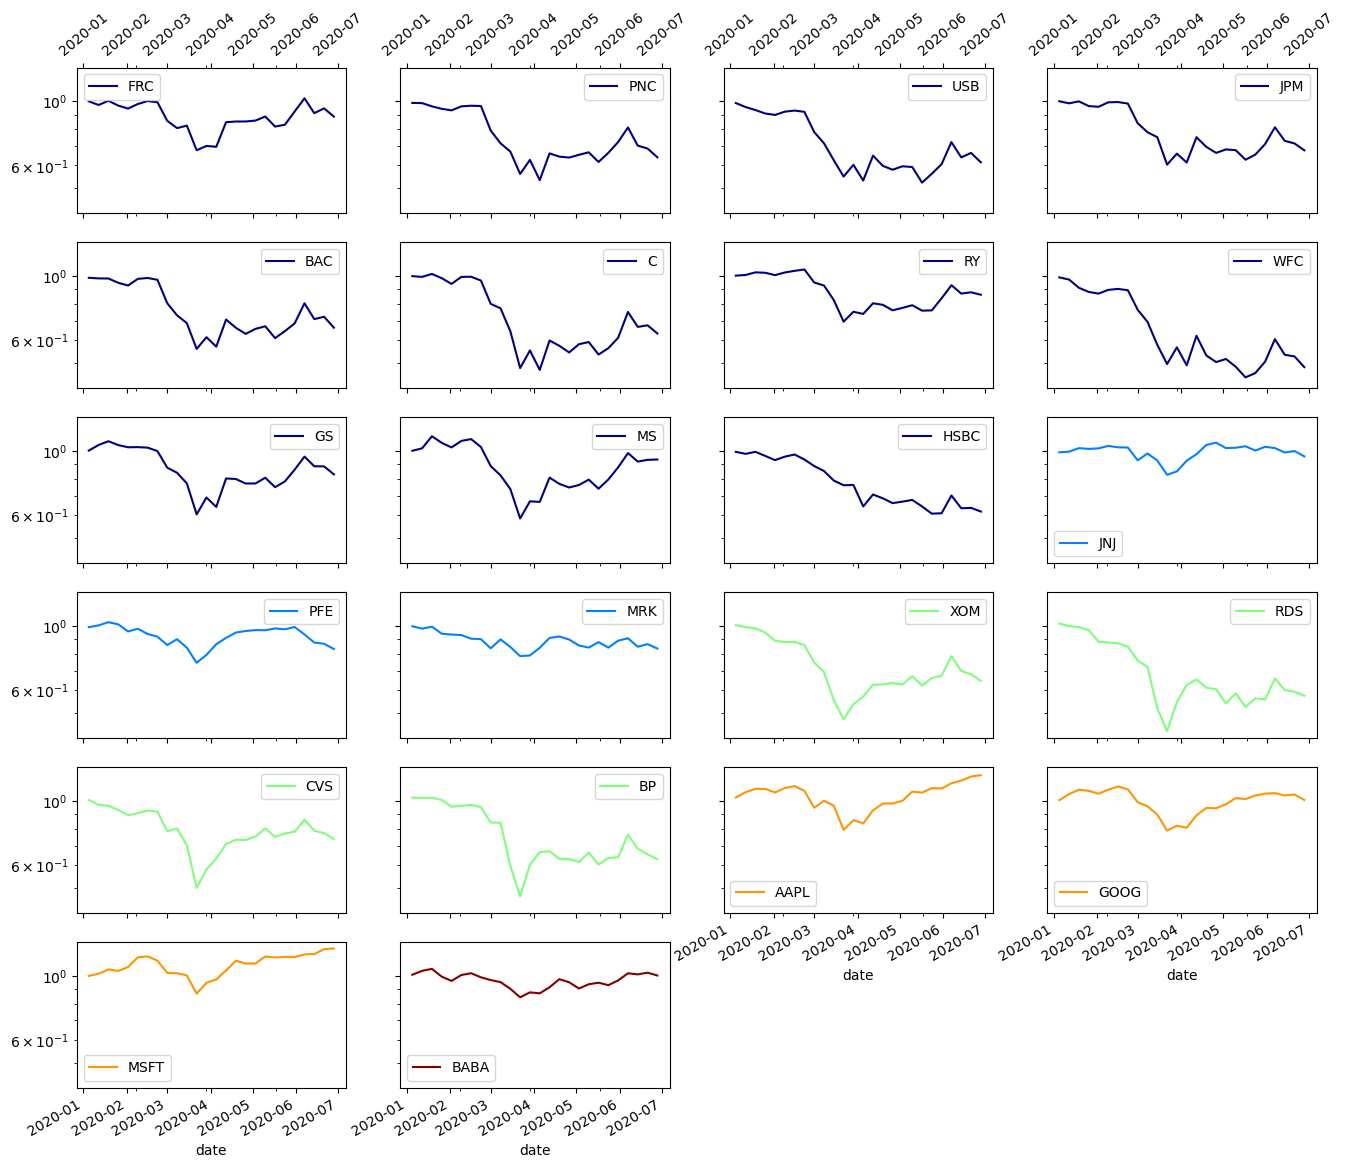

Summary Statistic Information from 12/30/2019 to 06/28/2020:


,Sector,Total Return(%),Ave Return(%),Annu. Ave Return(%),Annu. Std(%),Annu. Sharpe Ratio,Max Drawdown(%)
FRC,Bank,-11.45,-0.16,-8.11,57.39,-0.15,-32.56
PNC,Bank,-35.98,-1.27,-48.68,67.95,-0.74,-45.96
USB,Bank,-38.49,-1.44,-52.93,67.65,-0.80,-46.95
JPM,Bank,-32.30,-1.13,-44.75,62.17,-0.74,-39.64
BAC,Bank,-33.63,-1.14,-44.79,68.50,-0.67,-43.26
C,Bank,-36.64,-1.09,-43.39,83.90,-0.53,-53.47
RY,Bank,-13.72,-0.38,-17.95,44.40,-0.42,-34.02
WFC,Bank,-51.54,-2.22,-68.89,76.84,-0.92,-54.91
GS,Bank,-16.94,-0.32,-15.13,65.86,-0.24,-44.17
MS,Bank,-6.51,0.15,8.25,66.58,0.12,-48.07


In [16]:
print('Results over the time period ', start_date, ' to ', end_date, ':')
print()

# Output the Clustering information, graphical network plot,
# as well as summary statistics (optional) and the individual firm performance (optional)
# Store the correlation matrix and precision matrix in "est" (stands for estimates)
# Store the plotting configuration information in "con_fig" which will be needed if we want to use the ZOOM functions
## Note: you can view the correlation matrix by looking at est[0] and view the precision matrix by looking at est[1]
est, con_fig = graphicalAnalysis(data, start_date, end_date,
                                 Sectors_chosen, drop_firm,
                                 display_SumStat, display_IndRet)

Same color = Same cluster (makes sense as same color = same sector)

Can advise you about diversification as it can tell you which stocks in a specific sector has the strongest correlation with another stock in another sector.

You can also see the sparsity (GOOG is not connected to CVS, so they're not related).

C:\Users\kevin\AppData\Local\Temp\ipykernel_22820\1170210785.py:223: RuntimeWarning: invalid value encountered in divide
  edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),


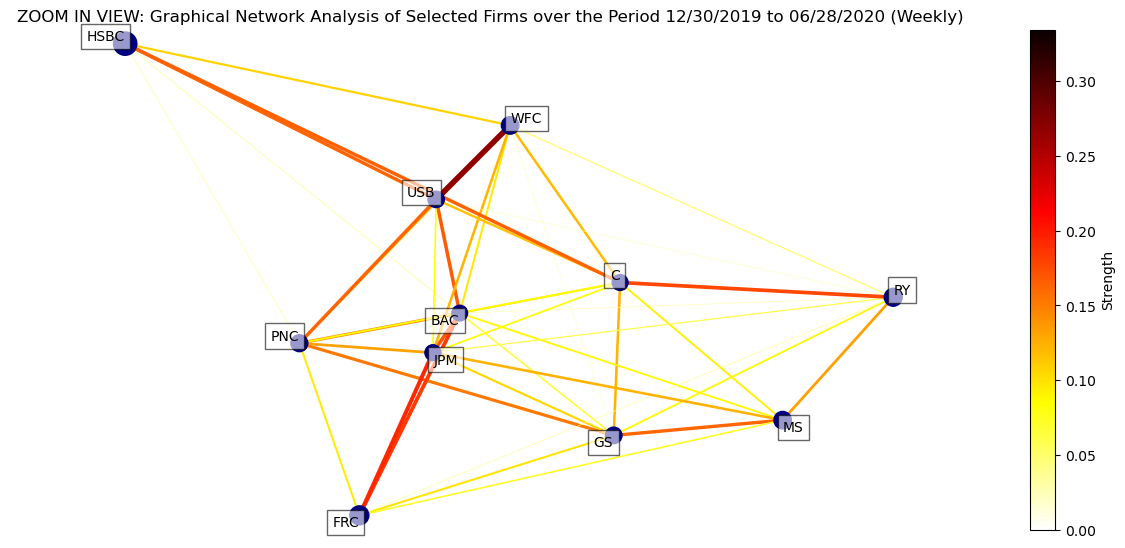

In [17]:
#look at bank sector
Sectors_list = ['Bank']

graphicalAnalysis_plot_ZOOM_bySector(Sectors_list, con_fig)

ZOOM IN View of the Selected Firms:
['FRC', 'JPM', 'BAC', 'GS', 'MS', 'PNC', 'C']


C:\Users\kevin\AppData\Local\Temp\ipykernel_22820\1170210785.py:223: RuntimeWarning: invalid value encountered in divide
  edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),


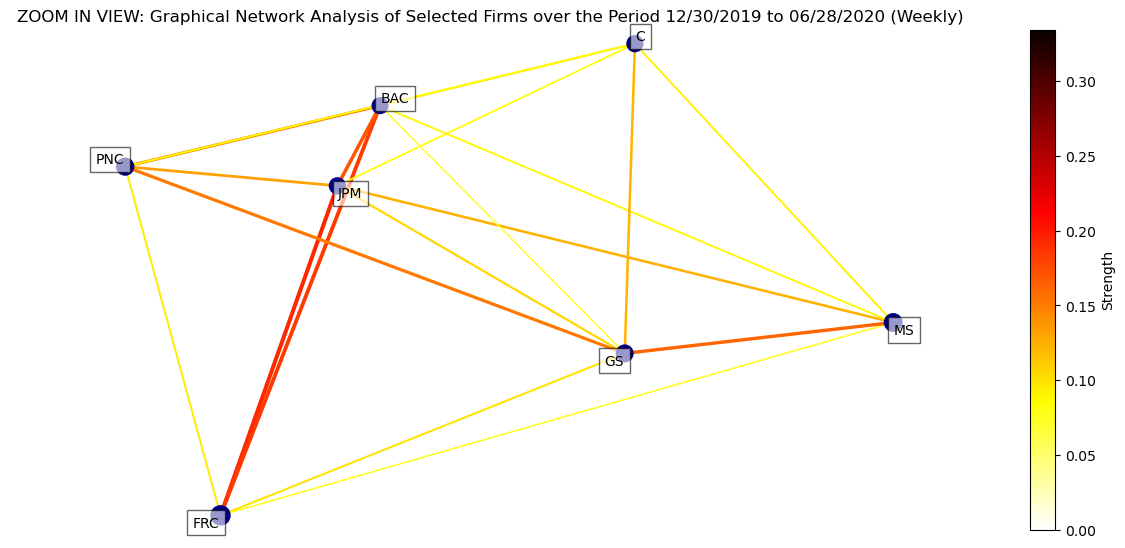

In [18]:
## The list of firms we want to look at more closely
# Note: These firms don't have to be from the same sector
# (but they need to be in the "Sectors_chosen" list if "Sectors_chosen" is different from default setting)

firms_list = ['FRC','JPM','BAC', 'GS', 'MS', 'PNC','C']
print('ZOOM IN View of the Selected Firms:')
print(firms_list)
#first one no zoom, second one zoom by sector, now we're zooming by firm.
graphicalAnalysis_plot_ZOOM_byFirm(firms_list, con_fig)

Distance = how closely related they are
Strength of correlation = color
Sparsity = Significant portion of data points are missing/zero (nodes connected only if they are conditionally dependent)

In [19]:
## Start and End date we are considering:
start_date = '2015-07-01'
end_date   = '2020-06-28'

## Sectors which we will be testing:
Sectors_chosen = ['Bank', 'Health', 'Energy', 'Tech']

## The list of firms we want to drop:
drop_firm = []

## Whether we want to display the summary statisitcs and/or individual firm performance:
display_SumStat = None
display_IndRet = None

Results over the time period 2015-07-01  to  2020-06-28 : 

Sectors choosen in the Graphical Analysis are:
['Bank', 'Health', 'Energy', 'Tech']

Number of firms examined: 22


c:\Users\kevin\anaconda3\envs\myenv\Lib\site-packages\numpy\_core\_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\kevin\anaconda3\envs\myenv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Cluster 1: FRC, PNC, USB, JPM, BAC, C, RY, WFC, GS, MS, HSBC
Cluster 2: JNJ, PFE, MRK
Cluster 3: XOM, RDS, CVS, BP
Cluster 4: AAPL, GOOG, MSFT
Cluster 5: BABA


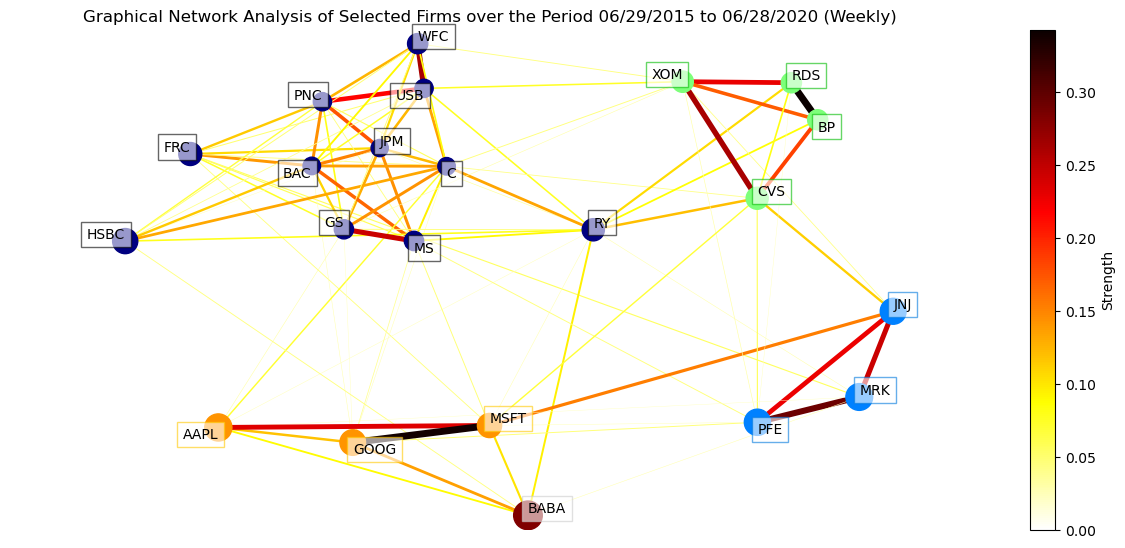

In [20]:
print('Results over the time period', start_date, ' to ', end_date, ': \n')
est, config = graphicalAnalysis(data, start_date, end_date, Sectors_chosen, drop_firm, display_SumStat, display_IndRet)

zooming in on the bank sector

In [21]:
Sectors_list = ['Bank']

C:\Users\kevin\AppData\Local\Temp\ipykernel_22820\1170210785.py:223: RuntimeWarning: invalid value encountered in divide
  edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),


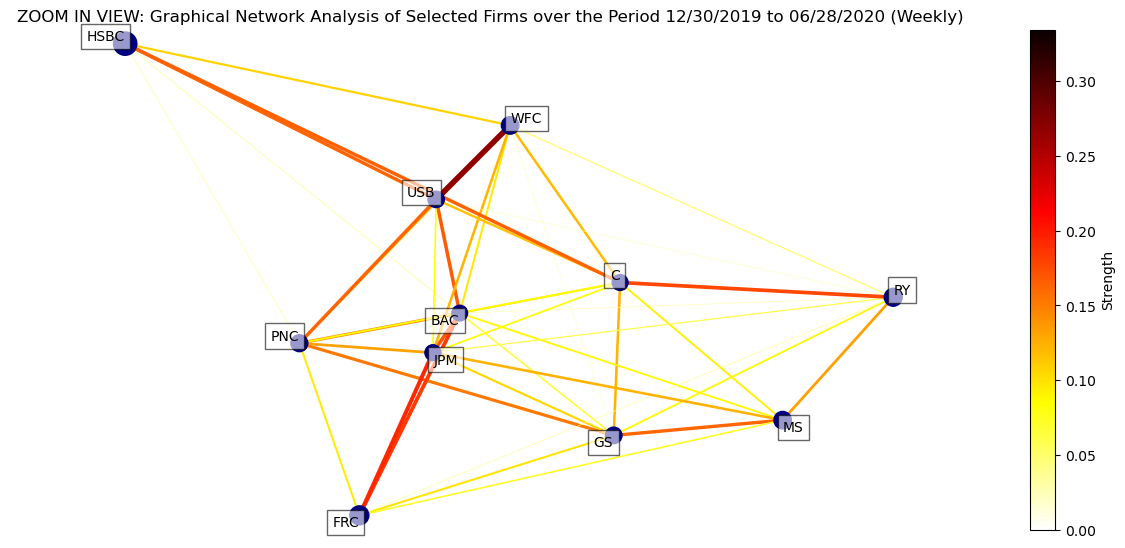

In [23]:
graphicalAnalysis_plot_ZOOM_bySector(Sectors_list, con_fig)

Looking at list of firms more closely in the sector

In [24]:
#firms do not have ot be from the same sector
firms_list = ['FRC','PNC','USB','BAC','GS','JPM','C','MS']

ZOOM IN View of the Selected Firms:
['FRC', 'PNC', 'USB', 'BAC', 'GS', 'JPM', 'C', 'MS']


C:\Users\kevin\AppData\Local\Temp\ipykernel_22820\1170210785.py:223: RuntimeWarning: invalid value encountered in divide
  edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),


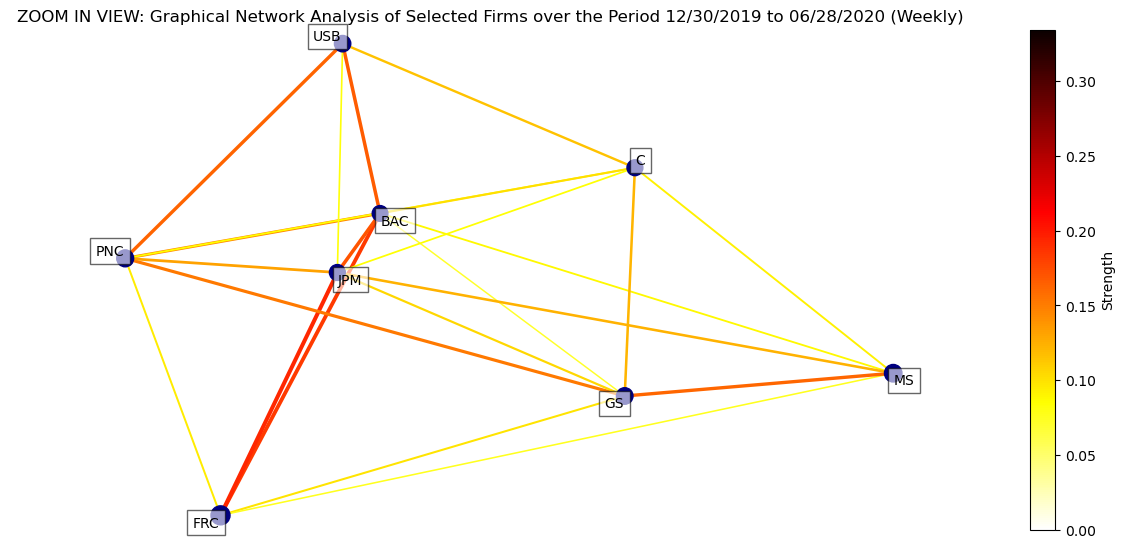

In [26]:
print('ZOOM IN View of the Selected Firms:')
print(firms_list)
graphicalAnalysis_plot_ZOOM_byFirm(firms_list, con_fig)

Graphical analysis for Bank, Health, Energy, and Tech sectors

In [28]:
#finding the first valid index for firm FRC
data['FRC'].first_valid_index()

firm_name = 'FRC'

start_date = '2010-12-12'
end_date = '2020-06-28'

Sectors_chosen = ['Bank', 'Health', 'Energy']

drop_firm = None

#no summary statistics nor individual firm performance
display_sumStat = None
display_IndRet = None

Graphical analysis results over the time period  2010-12-12  to  2020-06-28  for  FRC :

Sectors choosen in the Graphical Analysis are:
['Bank', 'Health', 'Energy']

Number of firms examined: 18


c:\Users\kevin\anaconda3\envs\myenv\Lib\site-packages\numpy\_core\_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\kevin\anaconda3\envs\myenv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Cluster 1: FRC, PNC, USB, JPM, BAC, C, RY, WFC, GS, MS, HSBC
Cluster 2: JNJ
Cluster 3: PFE
Cluster 4: MRK
Cluster 5: XOM, RDS, CVS, BP


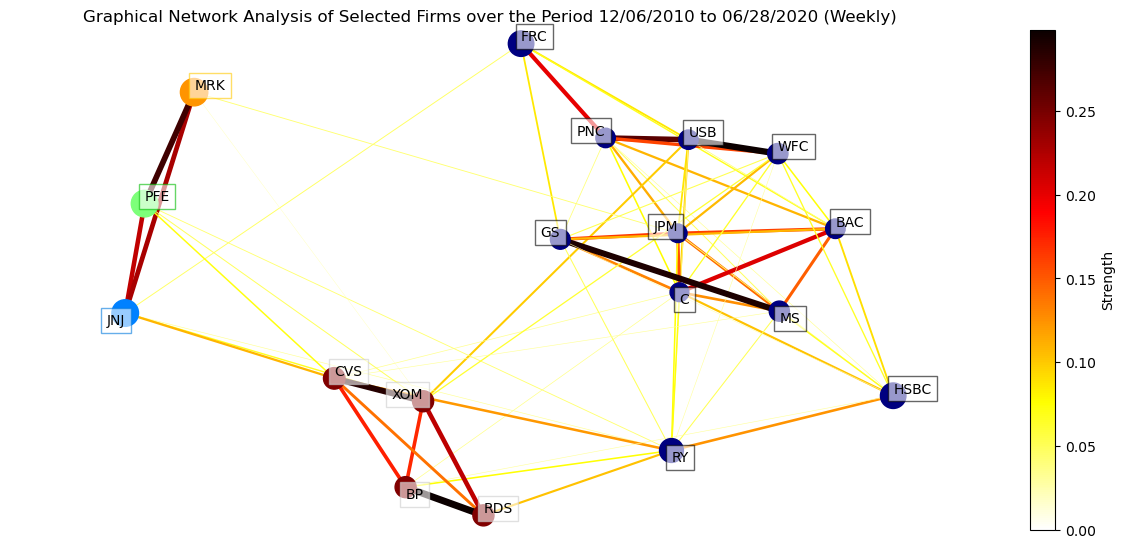

In [29]:
print('Graphical analysis results over the time period ', start_date, ' to ', end_date, ' for ', firm_name, ':')
print()
est, con_fig = graphicalAnalysis(data, start_date, end_date,
                                 Sectors_chosen, drop_firm,
                                 display_SumStat, display_IndRet)